# REDES NEURONALES

## Neurona

Una neurona está compuesta por unos parámetros de entrada (X), que provienen de la capa anterior, unos pesos relativos a cada parámetro (W) y un parámetro de bias (b).

La formula que se desarrolla en la neurona es:

$$ z = w_1x_1 + w_2x_2 + w_3x_3 + ... + b$$

Esto si se transforma en matrices sería:
$$\begin{bmatrix}
w_1\\
w_2 \\
w_3
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2 \\
x_3
\end{bmatrix}
$$

$$z = WX + b$$

Los resultados de la neurona (y), para que no sean lineales, se pasan por una función de activación a.

$$z = a(WX + b)$$

## Regresión lineal

$$ y = wx + b$$
$$ Y = WX + b$$

Lo que hay que "adivinar" es el valor de W y de b. 

Para calcular estos parámetros lo que se hace es intentar minimizar el error (la diferencia entre los valores predichos y los valores reales). Para cuantificar el error se utiliza la **funcion de coste (C)**. 

La funcion de coste en el caso de la regresión lineal es el ***error cuadrático medio***.
$$C = \frac{1}{n}\sum_{i=1}^{n} (y_{real_i} - y_{predicho_i})²$$

$$ C = (Y-XW)^T(Y-XW)$$

La función de coste lo que hace es relacionar el error (diferencia entre valores predichos y reales) con los parámetros que queremos ajustar (en este caso W)

Para calcular los parámetros lo que tenemos que hacer es encontrar el mínimo de la función de coste (este será el punto donde el error es mínimo) y nos dará el valor de W y de b. Para calcular el mínimo se deriva la función y se iguala a cero.

$$\frac{dC}{dW} = -2X^TY + 2X^TW$$

$$-2X^TY + 2X^TW = 0$$ 
$$W = (X^TX)^{-1}X^TY$$

Con el error cuadrático medio no tenemos problemas ya que la función es una parábola, y su único punto de pendiente 0 es su minimo. Sin embargo, en otras funciones la pendiente puede ser 0 en un máximo o en un punto de inflexión.

El problema es que la mayoria de funciones no son asi, por lo que hay que buscar otro método, ya que calcular todos los puntos de pendiente 0 sería muy costoso y ademas no nos daría solo los minimos sino minimos, maximos y puntos de inflexión. 

Es por eso que existe el **descenso del gradiente**

## Descenso del gradiente

Se calcula la derivada de la función de coste en un punto y esto nos da la pendiente de la función en ese punto. Al tener la pendiente en ese punto podemos saber en que sentido tenemos que modificar ese punto para descender en la función.

El descenso a lo largo de la función dependerá del **learning rate** y de la pendiente. El learning rate lo fijamos nosotros, y determina cuanto queremos avanzar por cada "punto" de pendiente. Cuanta más pendiente tengamos más vamos a descender, ya que estaremos más lejos del mínimo. 

- Si el *learning rate* es muy pequeño vamos a avanzar muy despacio, y además tenemos riesgo de quedarnos en un mínimo local.
- Si el *learning rate* es muy alto vamos a avanzar muy rapido, y es posible que no lleguemos a alcanzar ningún minimo porque avancemos tanto cada vez que siempre nos pasemos los valles.

El punto en el que vamos a calcular la derivada (la pendiente) es el punto en el que "nos encontramos", que nos lo dirá el valor del parámetro que queremos ajustar. Estamos en una función que relaciona el parámetro a ajustar con el error, vamos a calcular la pendiente en el punto en el que nos encontramos, para saber hacia donde tenemos que modificar el parámetro para disminuir el error.

## Backpropagation

Para poder calcular la derivada en un punto debemos saber cual es ese punto, y para eso tenemos que saber el error en cada neurona. Para saber el error en cada neurona repartimos el error final hacia atras en función del peso de cada una de las neuronas.

El error de cada neurona sería $C(a(z))$. Donde z es la suma ponderada de los parámetros de la neurona, a la función de activación y C la función de coste.

1. Partiendo del **error final**:
    - a: funcion de activación
    - z: resultado de la suma ponderada dentro de la neurona
$$\delta^L =  \frac{\partial C}{\partial a^L} \frac{\partial a^L}{\partial z^L}$$

2. Podemos calcular el **error en las capas previas**:
    - W: es la matriz de pesos de la capa siguiente

$$\delta^{L-1} =  \delta^L W^L \frac{\partial a^{L-1}}{\partial z^{L-1}}$$
    
3. Una vez que tenemos calculados los errores de cada capa calcular la **derivada de la función de coste** es muy sencillo:

- ***Para b***

$$\frac{\partial C}{\partial b^{L-1}} = \delta^{L-1}$$

- ***Para W***

$$\frac{\partial C}{\partial w^{L-1}} = \delta^{L-1} a^{L-2}$$

Aplicando estas fórmulas tendremos la pendiente en cada uno de los puntos, y con ello podremos saber hacia donde modificar los parámetros para minimizar el error

## Capas de la red

Podemos entender cada una de las capas de la red como un todo.

- **Inputs a cada neurona** (outputs de la capa previa)
$$
\begin{bmatrix}
x_1 & x_2 & x_3\\
\end{bmatrix}
$$

*En este caso serían tres inputs a cada neurona de esta capa*

- **Pesos para cada input**
$$
\begin{bmatrix}
w_{1,1} & w_{1,2} & w_{1,3}\\
w_{2,1} & w_{2,2} & w_{2,3}\\
w_{3,1} & w_{3,2} & w_{3,3}
\end{bmatrix}
$$

*En este caso serían tres neuronas con un peso para cada input*

- **Parámetro de bias**
$$
\begin{bmatrix}
b_{1}\\
b_{2}\\
b_{3}
\end{bmatrix}
$$

Si generamos una fórmula para cada capa quedaría

$$
\begin{bmatrix}
x_1 & x_2 & x_3\\
x_1 & x_2 & x_3\\
x_1 & x_2 & x_3
\end{bmatrix}
\begin{bmatrix}
w_{1,1} & w_{1,2} & w_{1,3}\\
w_{2,1} & w_{2,2} & w_{2,3}\\
w_{3,1} & w_{3,2} & w_{3,3}
\end{bmatrix}
\begin{bmatrix}
b_{1}\\
b_{2}\\
b_{3}
\end{bmatrix}= 
\begin{bmatrix}
z_{1}\\
z_{2}\\
z_{3}
\end{bmatrix}
$$

Luego habría que pasar los resultados por la **función de activación** de cada neurona

# Programacion de la red neuronal

Este es un notebook conducido originalmente por Carlos Santana Vega, re-escrito y comentado por Luis Arturo Cruz Cruz. Puedes consultar la fuente original en: https://www.youtube.com/watch?v=W8AeOXa_FqU

El objetivo de este ejercicio es clasificar un una clase , un dataset de puntos distribuidos de forma circular de otro dataset de puntos. Este problema de clasificación solo puede ser resuelto con una curva cerrada.

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

In [2]:
# Inicializar las variables n y p.
# Donde n es el tamaño dl dataset y p es el número de atributos que contiene un punto. 
n = 500
p = 2

## 1. Definimos el dataset que queremos clasificar.

A continuación, vamos a inicializar el dataset de puntos que vamos a clasificar. La variable X son las tuplas que contienen las coordenadas en el plano de cada punto, la variable Y es un vector que define a que clase (dos clases, 0 o 1) pertenece cada punto.**bold text**

(500, 1)


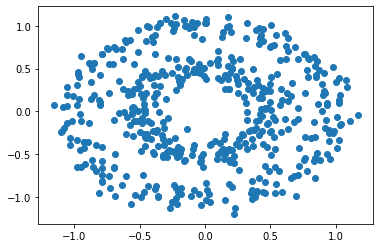

In [3]:
# El parámetro factor separa las dispersiones de puntos.
# El parámetro noise es el indice de disperción de los puntos en el plano.
X, Y = make_circles(n_samples=n, factor=0.5, noise = 0.1)

# Hay que añadirle una columna, sino solo es una lista
Y = Y[:, np.newaxis]
print(Y.shape)

plt.scatter(X[:, 0],X[:, 1] ) 
plt.show()

A continuación, vamos a visualizar los puntos, representando las clases en dos colores (0 para la clase "blue", 1 para la clase "red")

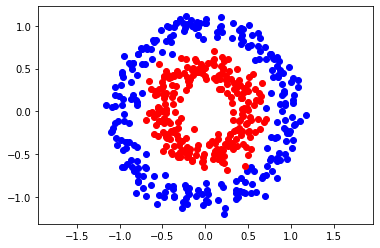

In [4]:
plt.scatter(X[Y[:, 0] == 0, 0],X[Y[:, 0] == 0, 1], c="blue" )
plt.scatter(X[Y[:, 0] == 1, 0],X[Y[:, 0] == 1, 1], c="red" )
plt.axis("equal")
plt.show()

A continuación, crearemos una clase (en el contexto del paradigma de POO) que contenga los atributos de una capa de neuronas. Esta estructura contiene el número de conexiones, el número de neuronas, la función de activación, el vector de sesgos y la matriz de pesos. Tanto el vector de sesgos como la matriz de pesos contienen valores al azar normalizados (valores aleatorios entre -1 y 1).

Pregunta 1: Entiendo porque los datos del vector de sesgos y de la matriz de pesos deben ser aleatorios, pero ¿Por qué deben ser normalizados y en un rango entre -1 y 1?

## 2. Definimos la estructura de la red neuronal.

### Clase capa

In [5]:
class neural_layer():
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f = act_f

        self.b = np.random.rand(1, n_neur)*2-1
        self.W = np.random.rand(n_conn, n_neur)*2-1      

### Funciones de activación

En la siguiente celda definiremos la función de activación de la tangente hiperbólica y su derivada. Ambas funciones están en una tupla, donde la primer componente de la tupla es la función y la segunda componente es su derivada.

$$\phi (x)= tanh (x) = \frac{e^{x}-e^{-x}}{e^{-x}+e^{x}}$$

$$\phi' (x)= sech^{2}(x) = \frac{4}{(e^{-x}+e^{x})^{2}}$$

In [6]:
tanh = (lambda x : ((np.e**x)-(np.e**(-x)))/((np.e**x)+(np.e**(-x))),
        lambda x : 4/((((np.e**x)+(np.e**(-x))))**2))

sig = (lambda x: 1 / (1 + np.e ** (-x)),
       lambda x: x * (1-x))

Esto es la función tangente y su derivada

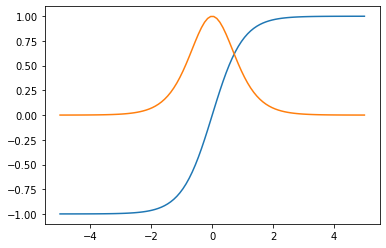

In [7]:
_x = np.linspace(-5,5, 100)
plt.plot(_x, tanh[0](_x))
plt.plot(_x, tanh[1](_x))

Esto es la funcion sigmoide y su derivada

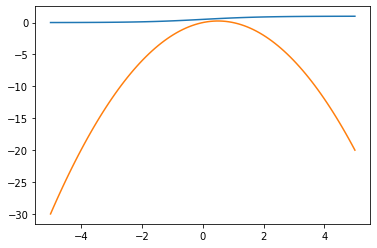

In [8]:
_x = np.linspace(-5,5, 100)
plt.plot(_x, sig[0](_x))
plt.plot(_x, sig[1](_x))

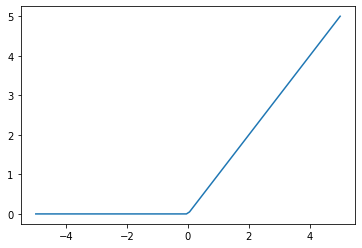

In [9]:
ReLu = lambda x : np.maximum(0,x)
_x = np.linspace(-5,5, 100)
plt.plot(_x, ReLu(_x))

### Funcion de creacion de la red

Es necesario notar, que la estructura ```neural_layer``` requiere de tres argumentos (número de conexiones a la entrada, número de neuronas en la capa, función de activación característica de la capa). 

In [10]:
# Capa de entrada
l0 = neural_layer(n_conn = p, n_neur = 4 , act_f = tanh) 
# Primera capa oculta
l1 = neural_layer(n_conn = 4, n_neur = 8 , act_f = tanh) 
#···

Para no tener que crear una por una todas las capas podemos crear un vector ```topology``` que recoja las neuronas de cada capa. Como los parametros de entrada son el numero de neuronas de la capa anterior, así ahorramos trabajo. 
El problema de esto es que solo podemos utilizar una misma función de activación para todas las capas.

Creamos una función para crear automáticamente todas las capas. La función ```create_nn``` requiere dos argumentos:

1.   El vector ```topology``` característico de la red, cada componente representa el número de neuronas por capa.

2.   La función de activación ```act_f``` , que para este proyecto será la misma en todas las capas. 



In [11]:
def create_nn(topology, act_f):
    nn = []
    # Por cada uno de los valores del vector topology
    # creamos una nueva capa, cuya entrada es el valor i y sus
    # neuronas son el valor i+1
    for l, layer in enumerate(topology[:-1]):
        nn.append(neural_layer(topology[l], topology[l+1] , act_f))

    return nn

**Creamos una red**

In [12]:
# Definimos las neuronas por capa
# Vector con el número de neuronas por cada
# La ultima neurona tiene que ser 1 porque nuestro output es si/no
topology = [p, 4, 5, 1]

# Creamos la red
neural_net = create_nn(topology, tanh)

In [13]:
neural_net

En este punto del proyecto la red neuronal ya está construida, pero no ha sido entrenada ni ajustada.

## 3. Definimos la función de entrenamiento de la red

### Función de coste

En la siguiente celda se puede observar, que la variable ```l2_cost``` se compone de una tupla de dos funciones lambda (sumatorias), donde la primera componente es la función de coste y la segunda componente es la derivada de la función de coste.

La función de coste se define de la siguiente manera (Error cuadrático medio):

$$MSE = \frac{1}{n}\sum_{i = 1}^{n}\left ( Y_{i} - \hat{Y}_{i} \right )^{2}$$

Pregunta: ¿Cómo se expresa la derivada de la función de coste?
Fuente: https://sebastianraschka.com/faq/docs/mse-derivative.html


In [14]:
# Definimos la función de coste y su derivada
# Yp: Y predicah
# Yr: Y real
l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr)**2), 
           lambda Yp, Yr: 2*(Yp - Yr))

### Funcion para el entrenamiento

La función de entrenamiento contempla los siguientes pasos:

 1. Propagación hacia adelante.
 2. Comparar resultados obtenidos con los esperados.
 3. Propagación hacia atras.

In [15]:
#Función de entrenamiento
def train(neural_net, X, Y, f_cost, lr = 0.5, train = True):
    
    # En este array guarda: 
    # - z: suma ponderada de cada capa
    # - a: valor tras la activación (output de la capa)
    # [(z0,a0),(z1,a1),...]
    # Se inicia con X, que es el primer valor de entrada
    out = [(None,X)]

    # 1. PRIMERA PROPAGACION HACIA ADELANTE
    for layer in neural_net:
        # Se recoge el ultimo output
        # out[-1] se refiere al ultimo valor 
        # [1] se refiere al output tras la funcion de activacion (a)
        last_output = out[-1][1]

        # Se calcula la suma ponderada
        z = last_output @ layer.W + layer.b
        # Se pasa por la funcion de activacion
        # [0] se refiere a la no derivada
        a = layer.act_f[0](z)

        # Se guardan los outputs de esta capa
        out.append((z,a))


    # Una vez realizada la propagacion hacia delante
    # 2. BACKPROPAGATION AND GRADIENT DESCENT
    if train:
        # Lista de errores
        delta = []

        for l in reversed(range(len(neural_net))):
            # De los outputs podemos sacar z y a
            # El +1 es porque el output de la capa 0 es 1
            # ya que el output 0 son los parametros de entrada X
            # out = [(None,X)]
            z = out[l+1][0]
            a = out[l+1][1]

            layer = neural_net[l]

            # Insert(0) sirve para añadir en la posicion 0, porque vamos hacia atras
            # El error se calcula diferente en la ultima capa que en el resto
            if l == len(neural_net) - 1:
                # Funcion 1
                error_ultima_capa = f_cost[1](a, Y) * layer.act_f[1](a)
                # Añadimos
                delta.insert(0, error_ultima_capa)
            else:
                error_previo = delta[0]
                W_previa = W_sin_modificar
                # Funcion 2
                error_resto_capas = (error_previo @ W_previa.T) * layer.act_f[1](a)
                # Añadimos
                delta.insert(0, error_resto_capas) 

            # La variable W se guarda porque sino, si la actualizamos en gradient descent 
            # y usamos la actualizada para calcular el siguiente error, estaría mal
            W_sin_modificar = layer.W 


            # GRADIENT DESCENT
            # Se ajustan los parametros segun las derivadas
            # Las derivadas se calculan en funcion de los errores ya calculados (funciones 3)
            error_atribuido = delta[0]

            # Parametro b
            # Se modifica en funcion del error medio de la capa anterior
            layer.b = layer.b - np.mean(error_atribuido, axis=0, keepdims=True) * lr

            # Parametro W
            # Se modifica en funcion del error de la capa anterior y la a
            a_previa = out[l][1].T
            layer.W = layer.W - (a_previa @ error_atribuido) * lr

    # Devolvemos el valor de output de la ultima capa
    return out[-1][1]

1. Error de la ultima capa

$$\delta^L =  \frac{\partial C}{\partial a^L} \frac{\partial a^L}{\partial z^L}$$

2. Error del resto de capas

$$\delta^{L-1} =  \delta^L W^L \frac{\partial a^{L-1}}{\partial z^{L-1}}$$

3. Calcular las derivadas de la capa usando el error

$$\frac{\partial C}{\partial b^{L-1}} = \delta^{L-1}$$

$$\frac{\partial C}{\partial w^{L-1}} = \delta^{L-1} a^{L-2}$$

Se puede decidir con cuantos datos se quiere hacer cada entrenamiento. A esto se le llama **batch**. Si hicieramos un entrenamiento solo con un dato, no serviría de nada, porque la función de error se calcularía solo con ese dato, sería como calcular la pendiente de la curva de regresión solo con un punto. 

Por otro lado, podemos usar los datos varias veces para ajustar los parámetros. El número de veces que se recorre el dataset entero se llama **epoch**. 

## 4. Enfrentamos a la red con los datos y presentamos resultados.

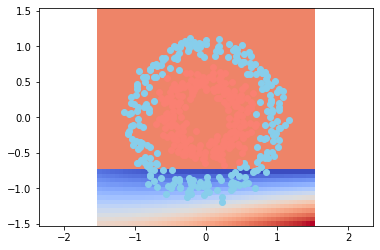

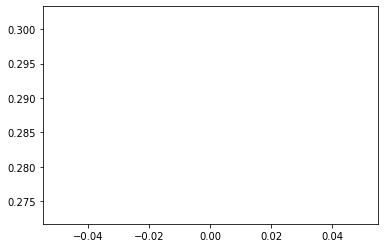

KeyboardInterrupt: 

In [16]:
import time
from IPython.display import clear_output

neural_n = create_nn(topology, tanh)
loss = []

# 1000 es el número de veces que vamos a actualizar los parámetros
# En este caso como cada bach es el dataset entero, 1000 tambien serán los epoch
for i in range(1000):
    #Entrenamos la red:
    pY = train(neural_n, X, Y, l2_cost, lr = 0.005)

    if i%100 == 0:

        loss.append(l2_cost[0](pY,Y))

        res = 50

        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)

        _Y = np.zeros((res, res))

        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _Y[i0, i1] = train(neural_n, np.array([[x0,x1]]), Y, l2_cost,train=False)[0][0]

            #Visualizamos los resultados del entrenamiento.
            plt.pcolormesh(_x0, _x1, _Y, cmap = "coolwarm")
            plt.axis("equal")

            plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c = "skyblue" )
            plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c = "salmon" )

            clear_output(wait = True)
            plt.show()
            plt.plot(range(len(loss)), loss)
            plt.show()
            time.sleep(0.5)
    
      

En este caso nuestro **bach** está siendo el dataset entero. Es decir, ajustamos los parámetros cada vez que le pasamos el dataset entero. Pero podríamos dividir el dataset en bloques e ir actualizando los parámetros más frecuentemente. 

Por otro lado aqui los **epoch** son el número de bucles que damos, ya que cada bucle recorre el dataset entero. Si dividieramos el dataset en tres, por ejemplo, entonces ya cada bucle no sería un **epoch**, un sino que un **epoch** sería cada tres bucles.

## Ver como funciona el entrenamiento desde dentro

In [146]:
#Función de entrenamiento
def train(neural_net, X, Y, f_cost, lr = 0.5, train = True):
    
    # En este array guarda: 
    # - z: suma ponderada de cada capa
    # - a: valor tras la activación (output de la capa)
    # [(z0,a0),(z1,a1),...]
    # Se inicia con X, que es el primer valor de entrada
    out = [(None,X)]

    # 1. PRIMERA PROPAGACION HACIA ADELANTE
    for layer in neural_net:
        print(f'LAYER: {layer}')
        # Se recoge el ultimo output
        # out[-1] se refiere al ultimo valor 
        # [1] se refiere al output tras la funcion de activacion (a)
        last_output = out[-1][1]
        
        print('Le introducidmos los valores del output previo: \n{}'.format(last_output))

        # Se calcula la suma ponderada
        z = last_output @ layer.W + layer.b
        print('z: \n{}'.format(z))
        # Se pasa por la funcion de activacion
        # [0] se refiere a la no derivada
        a = layer.act_f[0](z)
        print('Tras la activación: \n{}'.format(a))
        print('\n')

        # Se guardan los outputs de esta capa
        out.append((z,a))

    print('\n Iniciamos BACKPROPAGATION')
    # Una vez realizada la propagacion hacia delante
    # 2. BACKPROPAGATION AND GRADIENT DESCENT
    if train:
        # Lista de errores
        delta = []

        for l in reversed(range(len(neural_net))):
            # De los outputs podemos sacar z y a
            # El +1 es porque el output de la capa 0 es 1
            # ya que el output 0 son los parametros de entrada X
            # out = [(None,X)]
            z = out[l+1][0]
            a = out[l+1][1]

            layer = neural_net[l]
            
            print('\n\n LAYER {}: {}'.format(l+1, layer))

            # Insert(0) sirve para añadir en la posicion 0, porque vamos hacia atras
            # El error se calcula diferente en la ultima capa que en el resto
            if l == len(neural_net) - 1:
                print('Error final: {}\n'.format(f_cost[0](a, Y)))
                # Funcion 1
                print('Variación de la función de coste en función del '+
                'output: \n{}\n'.format(f_cost[1](a, Y)))
                error_ultima_capa = f_cost[1](a, Y) * layer.act_f[1](a)
                print('Varación de la función de coste en función de z \n'+
                'Se calcula como variación del coste respecto del output ' +
                'multiplicado por varación del output con respecto de z (chain rule)' +
                ': \n{}\n'.format(error_ultima_capa))
                # Añadimos
                delta.insert(0, error_ultima_capa)
            else:
                error_previo = delta[0]
                print('Variación de la función de coste de la capa {}: \n{}\n'.format(l+2,error_previo))
                W_previa = W_sin_modificar
                print('Valores de conexión entre capas: \n{}\n'.format(W_previa))
                print('Variación de la función de coste en ' +
                'función del output. \nSe calcula como la '+
                'variación de la función de coste de la capa ' +
                '{} multiplicada por los valores de conexión\n{}\n'.format(l+2,error_previo @ W_previa.T))

                # Funcion 2
                error_resto_capas = (error_previo @ W_previa.T) * layer.act_f[1](a)
                print('Variación de la función de coste con respecto de z. \n' +
                'Se calcula como variación del coste respecto del output ' +
                'multiplicado por varación del output con respecto de z (chain rule)' +
                ': \n{}\n'.format(error_resto_capas))
                # Añadimos
                delta.insert(0, error_resto_capas) 

            # La variable W se guarda porque sino, si la actualizamos en gradient descent 
            # y usamos la actualizada para calcular el siguiente error, estaría mal
            W_sin_modificar = layer.W 


            # GRADIENT DESCENT
            # Se ajustan los parametros segun las derivadas
            # Las derivadas se calculan en funcion de los errores ya calculados (funciones 3)
            error_atribuido = delta[0]

            # Parametro b
            # Se modifica en funcion del error medio de la capa anterior
            print('Varición de la función de coste respecto de b es la media de las variaciones ' + 
                  'con respecto de z \n{}\n'.format(-np.mean(np.mean(error_atribuido, axis=0, keepdims=True))))
            layer.b = layer.b - np.mean(error_atribuido, axis=0, keepdims=True) * lr

            # Parametro W
            # Se modifica en funcion del error de la capa anterior y la a
            a_previa = out[l][1].T
            print('Input de esta capa: \n{}\n'.format(a_previa))
            print('Variación de la función de coste con respecto de w \n' +
                  'Es la variación de la función de coste con respecto de z, multiplicado ' +
                  'por el input \n{}\n'.format(a_previa @ error_atribuido))
            layer.W = layer.W - (a_previa @ error_atribuido) * lr

In [147]:
X_prueba = X[0:5]
Y_prueba = Y[0:5]

In [148]:
topoloty = [1,2,1]
neural_n = create_nn(topology, tanh)

In [149]:
train(neural_n, X_prueba, Y_prueba, l2_cost)

LAYER: <__main__.neural_layer object at 0x7fad36b3c580>
Le introducidmos los valores del output previo: 
[[-0.09538597 -0.44041448]
 [-0.86964774  0.14310777]
 [-0.48566466 -0.1306656 ]
 [-1.00902955  0.18145479]
 [ 0.00833148 -1.03539391]]
z: 
[[ 0.42782086 -0.02343278  0.56856807 -1.50294806]
 [-0.20606534 -0.6672576   0.31242828 -1.53586739]
 [ 0.10009941 -0.35858387  0.4461241  -1.50425489]
 [-0.28514691 -0.73779213  0.23784035 -1.60708739]
 [ 0.78416526  0.41433342  0.38221741 -2.00447083]]
Tras la activación: 
[[ 0.40349857 -0.02342849  0.51430689 -0.90567957]
 [-0.20319733 -0.58317304  0.30264458 -0.91142332]
 [ 0.09976642 -0.34396606  0.41870781 -0.90591419]
 [-0.27766194 -0.62780936  0.23345483 -0.92272846]
 [ 0.65509096  0.39214594  0.36463161 -0.96434209]]


LAYER: <__main__.neural_layer object at 0x7fad36b3d390>
Le introducidmos los valores del output previo: 
[[ 0.40349857 -0.02342849  0.51430689 -0.90567957]
 [-0.20319733 -0.58317304  0.30264458 -0.91142332]
 [ 0.09976642

## Fin del Notebook